<a href="https://colab.research.google.com/github/DavianYang/kan-cnn-study/blob/main/shallow_mlp_kan_cifar10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
import torch.optim as optim
import torch.nn.functional as F
import torch.nn as nn
from torch.utils.data import DataLoader

import math
import matplotlib.pyplot as plt
import time
import wandb

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
# https://github.com/Blealtan/efficient-kan/tree/master/src/efficient_kan

import torch
import torch.nn.functional as F
import math


class KANLinear(torch.nn.Module):
    def __init__(
        self,
        in_features,
        out_features,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        enable_standalone_scale_spline=True,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KANLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.grid_size = grid_size
        self.spline_order = spline_order

        h = (grid_range[1] - grid_range[0]) / grid_size
        grid = (
            (
                torch.arange(-spline_order, grid_size + spline_order + 1) * h
                + grid_range[0]
            )
            .expand(in_features, -1)
            .contiguous()
        )
        self.register_buffer("grid", grid)

        self.base_weight = torch.nn.Parameter(torch.Tensor(out_features, in_features))
        self.spline_weight = torch.nn.Parameter(
            torch.Tensor(out_features, in_features, grid_size + spline_order)
        )
        if enable_standalone_scale_spline:
            self.spline_scaler = torch.nn.Parameter(
                torch.Tensor(out_features, in_features)
            )

        self.scale_noise = scale_noise
        self.scale_base = scale_base
        self.scale_spline = scale_spline
        self.enable_standalone_scale_spline = enable_standalone_scale_spline
        self.base_activation = base_activation()
        self.grid_eps = grid_eps

        self.reset_parameters()

    def reset_parameters(self):
        torch.nn.init.kaiming_uniform_(self.base_weight, a=math.sqrt(5) * self.scale_base)
        with torch.no_grad():
            noise = (
                (
                    torch.rand(self.grid_size + 1, self.in_features, self.out_features)
                    - 1 / 2
                )
                * self.scale_noise
                / self.grid_size
            )
            self.spline_weight.data.copy_(
                (self.scale_spline if not self.enable_standalone_scale_spline else 1.0)
                * self.curve2coeff(
                    self.grid.T[self.spline_order : -self.spline_order],
                    noise,
                )
            )
            if self.enable_standalone_scale_spline:
                # torch.nn.init.constant_(self.spline_scaler, self.scale_spline)
                torch.nn.init.kaiming_uniform_(self.spline_scaler, a=math.sqrt(5) * self.scale_spline)

    def b_splines(self, x: torch.Tensor):
        """
        Compute the B-spline bases for the given input tensor.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).

        Returns:
            torch.Tensor: B-spline bases tensor of shape (batch_size, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features

        grid: torch.Tensor = (
            self.grid
        )  # (in_features, grid_size + 2 * spline_order + 1)
        x = x.unsqueeze(-1)
        bases = ((x >= grid[:, :-1]) & (x < grid[:, 1:])).to(x.dtype)
        for k in range(1, self.spline_order + 1):
            bases = (
                (x - grid[:, : -(k + 1)])
                / (grid[:, k:-1] - grid[:, : -(k + 1)])
                * bases[:, :, :-1]
            ) + (
                (grid[:, k + 1 :] - x)
                / (grid[:, k + 1 :] - grid[:, 1:(-k)])
                * bases[:, :, 1:]
            )

        assert bases.size() == (
            x.size(0),
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return bases.contiguous()

    def curve2coeff(self, x: torch.Tensor, y: torch.Tensor):
        """
        Compute the coefficients of the curve that interpolates the given points.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, in_features).
            y (torch.Tensor): Output tensor of shape (batch_size, in_features, out_features).

        Returns:
            torch.Tensor: Coefficients tensor of shape (out_features, in_features, grid_size + spline_order).
        """
        assert x.dim() == 2 and x.size(1) == self.in_features
        assert y.size() == (x.size(0), self.in_features, self.out_features)

        A = self.b_splines(x).transpose(
            0, 1
        )  # (in_features, batch_size, grid_size + spline_order)
        B = y.transpose(0, 1)  # (in_features, batch_size, out_features)
        solution = torch.linalg.lstsq(
            A, B
        ).solution  # (in_features, grid_size + spline_order, out_features)
        result = solution.permute(
            2, 0, 1
        )  # (out_features, in_features, grid_size + spline_order)

        assert result.size() == (
            self.out_features,
            self.in_features,
            self.grid_size + self.spline_order,
        )
        return result.contiguous()

    @property
    def scaled_spline_weight(self):
        return self.spline_weight * (
            self.spline_scaler.unsqueeze(-1)
            if self.enable_standalone_scale_spline
            else 1.0
        )

    def forward(self, x: torch.Tensor):
        assert x.size(-1) == self.in_features
        original_shape = x.shape
        x = x.reshape(-1, self.in_features)

        base_output = F.linear(self.base_activation(x), self.base_weight)
        spline_output = F.linear(
            self.b_splines(x).view(x.size(0), -1),
            self.scaled_spline_weight.view(self.out_features, -1),
        )
        output = base_output + spline_output

        output = output.reshape(*original_shape[:-1], self.out_features)
        return output

    @torch.no_grad()
    def update_grid(self, x: torch.Tensor, margin=0.01):
        assert x.dim() == 2 and x.size(1) == self.in_features
        batch = x.size(0)

        splines = self.b_splines(x)  # (batch, in, coeff)
        splines = splines.permute(1, 0, 2)  # (in, batch, coeff)
        orig_coeff = self.scaled_spline_weight  # (out, in, coeff)
        orig_coeff = orig_coeff.permute(1, 2, 0)  # (in, coeff, out)
        unreduced_spline_output = torch.bmm(splines, orig_coeff)  # (in, batch, out)
        unreduced_spline_output = unreduced_spline_output.permute(
            1, 0, 2
        )  # (batch, in, out)

        # sort each channel individually to collect data distribution
        x_sorted = torch.sort(x, dim=0)[0]
        grid_adaptive = x_sorted[
            torch.linspace(
                0, batch - 1, self.grid_size + 1, dtype=torch.int64, device=x.device
            )
        ]

        uniform_step = (x_sorted[-1] - x_sorted[0] + 2 * margin) / self.grid_size
        grid_uniform = (
            torch.arange(
                self.grid_size + 1, dtype=torch.float32, device=x.device
            ).unsqueeze(1)
            * uniform_step
            + x_sorted[0]
            - margin
        )

        grid = self.grid_eps * grid_uniform + (1 - self.grid_eps) * grid_adaptive
        grid = torch.concatenate(
            [
                grid[:1]
                - uniform_step
                * torch.arange(self.spline_order, 0, -1, device=x.device).unsqueeze(1),
                grid,
                grid[-1:]
                + uniform_step
                * torch.arange(1, self.spline_order + 1, device=x.device).unsqueeze(1),
            ],
            dim=0,
        )

        self.grid.copy_(grid.T)
        self.spline_weight.data.copy_(self.curve2coeff(x, unreduced_spline_output))

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        """
        Compute the regularization loss.

        This is a dumb simulation of the original L1 regularization as stated in the
        paper, since the original one requires computing absolutes and entropy from the
        expanded (batch, in_features, out_features) intermediate tensor, which is hidden
        behind the F.linear function if we want an memory efficient implementation.

        The L1 regularization is now computed as mean absolute value of the spline
        weights. The authors implementation also includes this term in addition to the
        sample-based regularization.
        """
        l1_fake = self.spline_weight.abs().mean(-1)
        regularization_loss_activation = l1_fake.sum()
        p = l1_fake / regularization_loss_activation
        regularization_loss_entropy = -torch.sum(p * p.log())
        return (
            regularize_activation * regularization_loss_activation
            + regularize_entropy * regularization_loss_entropy
        )


class KAN(torch.nn.Module):
    def __init__(
        self,
        layers_hidden,
        grid_size=5,
        spline_order=3,
        scale_noise=0.1,
        scale_base=1.0,
        scale_spline=1.0,
        base_activation=torch.nn.SiLU,
        grid_eps=0.02,
        grid_range=[-1, 1],
    ):
        super(KAN, self).__init__()
        self.grid_size = grid_size
        self.spline_order = spline_order

        self.layers = torch.nn.ModuleList()
        for in_features, out_features in zip(layers_hidden, layers_hidden[1:]):
            self.layers.append(
                KANLinear(
                    in_features,
                    out_features,
                    grid_size=grid_size,
                    spline_order=spline_order,
                    scale_noise=scale_noise,
                    scale_base=scale_base,
                    scale_spline=scale_spline,
                    base_activation=base_activation,
                    grid_eps=grid_eps,
                    grid_range=grid_range,
                )
            )

    def forward(self, x: torch.Tensor, update_grid=False):
        for layer in self.layers:
            if update_grid:
                layer.update_grid(x)
            x = layer(x)
        return x

    def regularization_loss(self, regularize_activation=1.0, regularize_entropy=1.0):
        return sum(
            layer.regularization_loss(regularize_activation, regularize_entropy)
            for layer in self.layers
        )

In [4]:
# Define color codes for terminal
class Colors:
    RESET = '\033[0m'
    GREEN = '\033[92m'
    RED = '\033[91m'
    YELLOW = '\033[93m'
    CYAN = '\033[96m'

def display_progress_bar(batch_idx, num_batches, loss, accuracy):
    """
    Function to display a colored progress bar.
    Args:
        batch_idx: Current batch index
        num_batches: Total number of batches
        loss: Current loss value
        accuracy: Current accuracy value
    """
    progress = (batch_idx + 1) / num_batches
    bar_length = 40  # Length of the progress bar (number of '==' chars)
    filled_length = int(bar_length * progress)
    bar = f"{Colors.GREEN}{'=' * filled_length}{Colors.RED}{'-' * (bar_length - filled_length)}{Colors.RESET}"

    print(f'\r[{bar}] {batch_idx + 1}/{num_batches} | {Colors.YELLOW}Loss:{Colors.RESET} {loss:.3f} | {Colors.YELLOW}Accuracy:{Colors.RESET} {accuracy:.2f}%', end='', flush=True)

In [5]:
import matplotlib.pyplot as plt

def plot_result(history, title="Training Progress"):
    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], label='Train', color='tomato')
    plt.plot(epochs, history['val_loss'], label='Validation', color='steelblue')
    plt.title("Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend(frameon=False)
    plt.grid(True, linestyle="--", alpha=0.3)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], label='Train', color='mediumseagreen')
    plt.plot(epochs, history['val_acc'], label='Validation', color='black')
    plt.title("Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend(frameon=False)
    plt.grid(True, linestyle="--", alpha=0.3)

    plt.suptitle(title, fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


In [6]:
def train_model(model, trainloader, valloader, device,
                             optimizer, criterion, epochs=10, input_dim=None,
                             use_wandb=False, project_name=None, show_progress=True):
    model.to(device)
    start_time = time.time()

    train_loss_values, train_acc_values = [], []
    val_loss_values, val_acc_values = [], []

    if use_wandb:
        wandb.init(project=project_name)
        wandb.watch(model, log="all")

    for epoch in range(epochs):
        # ---------- Training ----------
        model.train()
        train_loss, correct, total = 0.0, 0, 0
        num_train_batches = len(trainloader)

        print(f"\nEpoch {epoch + 1}/{epochs} - Training")

        for batch_idx, (inputs, targets) in enumerate(trainloader):
            if input_dim is not None:
                inputs = inputs.view(-1, input_dim * input_dim * 3).to(device)
            else:
                inputs = inputs.to(device)
            targets = targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            if show_progress:
                acc = 100. * correct / total
                avg_loss = train_loss / (batch_idx + 1)
                display_progress_bar(batch_idx, num_train_batches, avg_loss, acc)

        train_epoch_loss = train_loss / num_train_batches
        train_epoch_acc = 100. * correct / total
        train_loss_values.append(train_epoch_loss)
        train_acc_values.append(train_epoch_acc)

        # ---------- Evaluation ----------
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        all_preds, all_targets = [], []
        num_val_batches = len(valloader)

        print(f"\nEpoch {epoch + 1}/{epochs} - Evaluation")

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(valloader):
                if input_dim is not None:
                    inputs = inputs.view(-1, input_dim * input_dim * 3).to(device)
                else:
                    inputs = inputs.to(device)
                targets = targets.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, targets)

                val_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                all_preds.extend(predicted.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())

                if show_progress:
                    acc = 100. * correct / total
                    avg_loss = val_loss / (batch_idx + 1)
                    display_progress_bar(batch_idx, num_val_batches, avg_loss, acc)

        val_epoch_loss = val_loss / num_val_batches
        val_epoch_acc = 100. * correct / total
        val_loss_values.append(val_epoch_loss)
        val_acc_values.append(val_epoch_acc)

        print(f"\nTrain Loss: {train_epoch_loss:.4f}, Train Acc: {train_epoch_acc:.2f}%")
        print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Acc: {val_epoch_acc:.2f}%")

        if use_wandb:
            wandb.log({
                "Train Loss": train_epoch_loss,
                "Train Accuracy": train_epoch_acc,
                "Validation Loss": val_epoch_loss,
                "Validation Accuracy": val_epoch_acc,
                "Epoch": epoch + 1
            })

    elapsed = time.time() - start_time
    print(f"\nTraining complete in {elapsed // 60:.0f}m {elapsed % 60:.0f}s.")

    if use_wandb:
        wandb.finish()

    return {
        "model": model,
        "train_loss": train_loss_values,
        "train_acc": train_acc_values,
        "val_loss": val_loss_values,
        "val_acc": val_acc_values,
        "predictions": all_preds,
        "targets": all_targets
    }


In [7]:
def count_parameters(model):
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params, trainable_params

In [8]:
# Transform to normalize the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize to [-1, 1]
])

# Load CIFAR-10 dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

trainloader = DataLoader(trainset, batch_size=64, shuffle=True)
valloader = DataLoader(valset, batch_size=64, shuffle=False)

100%|██████████| 170M/170M [00:13<00:00, 12.7MB/s]


In [9]:
class ShallowNet(nn.Module):
  def __init__(self, height, width, depth, classes):
    super(ShallowNet, self).__init__()

    self.conv1 = nn.Conv2d(in_channels=depth, out_channels=32, kernel_size=3, padding='same')
    self.fc1 = nn.Linear(32 * height * width, classes)

  def forward(self, x):
    x = self.conv1(x)
    x = F.relu(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)

    return x

In [10]:
classes = 10
input_dim = 32
lr = 0.01
epochs = 30
batch_size = 64

In [11]:
shallow_mlp = ShallowNet(height=32, width=32, depth=3, classes=10)

total_params_mlp, trainable_params_mlp = count_parameters(shallow_mlp)
print(f"Total parameters: {total_params_mlp}")
print(f"Trainable parameters: {trainable_params_mlp}")

optimizer = optim.SGD(shallow_mlp.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

shallow_mlp

Total parameters: 328586
Trainable parameters: 328586


ShallowNet(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
  (fc1): Linear(in_features=32768, out_features=10, bias=True)
)

In [ ]:
result = train_model(shallow_mlp, trainloader, valloader, device, optimizer, criterion, epochs)


Epoch 1/30 - Training
[========================================] 782/782 | Loss: 1.486 | Accuracy: 47.86%
Epoch 1/30 - Evaluation
[========================================] 157/157 | Loss: 1.313 | Accuracy: 53.63%
Train Loss: 1.4859, Train Acc: 47.86%
Validation Loss: 1.3135, Validation Acc: 53.63%

Epoch 2/30 - Training
[========================================] 782/782 | Loss: 1.206 | Accuracy: 58.33%
Epoch 2/30 - Evaluation
[========================================] 157/157 | Loss: 1.206 | Accuracy: 58.20%
Train Loss: 1.2056, Train Acc: 58.33%
Validation Loss: 1.2055, Validation Acc: 58.20%

Epoch 3/30 - Training
[========================================] 782/782 | Loss: 1.065 | Accuracy: 63.57%
Epoch 3/30 - Evaluation
[========================================] 157/157 | Loss: 1.209 | Accuracy: 59.39%
Train Loss: 1.0650, Train Acc: 63.57%
Validation Loss: 1.2085, Validation Acc: 59.39%

Epoch 4/30 - Training
[========================================] 782/782 | Loss: 0.972 | Accurac

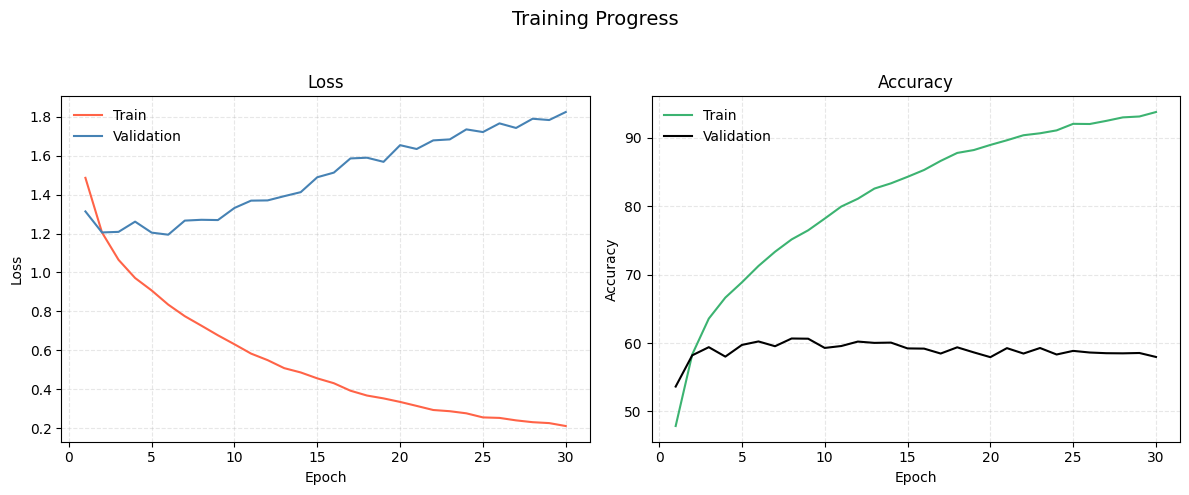

In [ ]:
plot_result(result)

In [ ]:
shallow_kan = KAN([input_dim * input_dim * 3, classes], grid_size=5, spline_order=3)

total_params_kan, trainable_params_kan = count_parameters(shallow_kan)
print(f"Total parameters: {total_params_kan}")
print(f"Trainable parameters: {trainable_params_kan}")

optimizer = optim.SGD(shallow_kan.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)
criterion = nn.CrossEntropyLoss()

Total parameters: 307200
Trainable parameters: 307200


In [ ]:
result_kan = train_model(shallow_kan, trainloader, valloader, device,
                                  optimizer, criterion,
                                  epochs, input_dim=32)


Epoch 1/30 - Training
[========================================] 782/782 | Loss: 1.864 | Accuracy: 36.06%
Epoch 1/30 - Evaluation
[========================================] 157/157 | Loss: 1.818 | Accuracy: 37.93%
Train Loss: 1.8637, Train Acc: 36.06%
Validation Loss: 1.8176, Validation Acc: 37.93%

Epoch 2/30 - Training
[========================================] 782/782 | Loss: 1.785 | Accuracy: 39.03%
Epoch 2/30 - Evaluation
[========================================] 157/157 | Loss: 1.790 | Accuracy: 38.81%
Train Loss: 1.7847, Train Acc: 39.03%
Validation Loss: 1.7904, Validation Acc: 38.81%

Epoch 3/30 - Training
[========================================] 782/782 | Loss: 1.756 | Accuracy: 40.29%
Epoch 3/30 - Evaluation
[========================================] 157/157 | Loss: 1.764 | Accuracy: 39.85%
Train Loss: 1.7563, Train Acc: 40.29%
Validation Loss: 1.7636, Validation Acc: 39.85%

Epoch 4/30 - Training
[========================================] 782/782 | Loss: 1.738 | Accurac

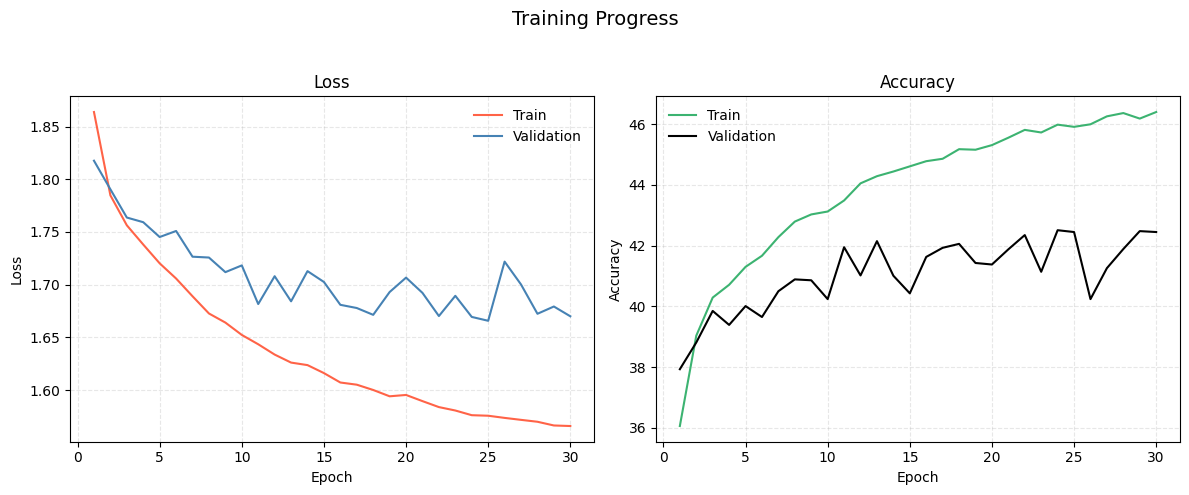

In [ ]:
plot_result(result_kan)